In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import ExtraTreeClassifier
# from sklearn.externals import joblib#Predict popularity of song based on characteristics 
df = pd.read_csv('data/data.csv')

In [2]:
df.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


In [3]:
df.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')

In [4]:
#Measure accuracy of model depending on genre being present 
X = df[['valence','acousticness','danceability','energy','loudness','speechiness','tempo']]

In [5]:
def popularity_category(pop):
    #Low pop lower 25% of data
    if pop <= 11:
        return 0
    #Average between low and popular
    elif pop > 11 and pop < 48:
        return 1
    #Popular: More popular than 75% of all songs right now
    else:
        return 2
def get_decade(year):
    str_year = str(year)[:-1] + '0'
    return int(str_year)
y = df['year'].apply(get_decade)
y

0         1920
1         1920
2         1920
3         1920
4         1920
          ... 
170648    2020
170649    2020
170650    2020
170651    2020
170652    2020
Name: year, Length: 170653, dtype: int64

In [25]:
###### PCA Kmeans on data #####
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans # Our clustering algorithm
from sklearn.decomposition import PCA # Needed for dimension reduction
from sklearn.datasets import load_wine # Dataset that I will be using
import matplotlib.pyplot as plt # Plotting 
import pandas as pd # Storing data convenieniently
features = df[['valence','acousticness', 'danceability',
       'energy', 'instrumentalness',
       'liveness', 'loudness',
       'speechiness', 'tempo']]
#features = df[['instrumentalness', 'speechiness', 'valence']]
features_norm = MinMaxScaler().fit_transform(features) # normalizing the data 

In [26]:
pca = PCA()
pca.fit(features_norm)
evr = pca.explained_variance_ratio_
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print(n_comps)

4


In [27]:
pca = PCA(n_components=  n_comps)
principalComponents = pca.fit_transform(features_norm)
features_norm

array([[0.0594    , 0.98594378, 0.28238866, ..., 0.62491582, 0.03773196,
        0.3324504 ],
       [0.963     , 0.73493976, 0.82894737, ..., 0.74479681, 0.42783505,
        0.25024332],
       [0.0394    , 0.96485944, 0.33198381, ..., 0.70707071, 0.03494845,
        0.45312455],
       ...,
       [0.637     , 0.10140562, 0.6417004 , ..., 0.90476862, 0.08340206,
        0.37653127],
       [0.195     , 0.01002008, 0.6791498 , ..., 0.82748414, 0.31752577,
        0.30822523],
       [0.642     , 0.13253012, 0.86639676, ..., 0.862454  , 0.11134021,
        0.39009556]])

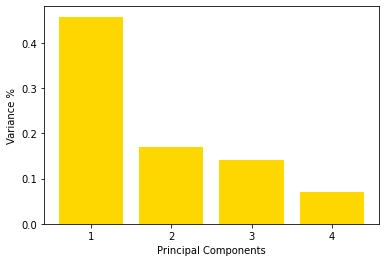

In [28]:
# Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)

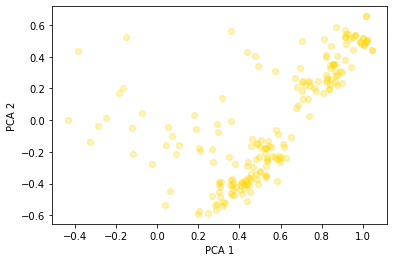

In [29]:
plt.scatter(PCA_components[0][0:200], PCA_components[1][0:200], alpha=.3, color='gold')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

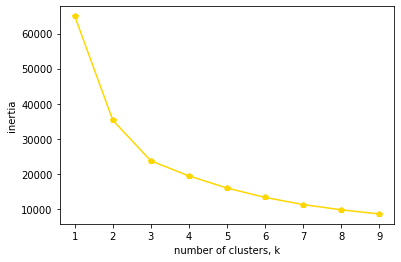

In [30]:
inertias = []

# Creating 10 K-Mean models while varying the number of clusters (k)
for k in range(1,10):
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(range(1,10), inertias, '-p', color='gold')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
#plt.xticks(ks)
plt.show()

In [31]:
inertias

[64951.20355613635,
 35256.539292018075,
 23694.231212604725,
 19400.514669591004,
 15941.883134431037,
 13270.118778685504,
 11230.916732725282,
 9723.530575314646,
 8553.546241713224]

In [43]:
model = KMeans(n_clusters=2973)
model.fit(PCA_components.iloc[:,:2])

labels = model.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

KeyboardInterrupt: 

In [34]:
labels

array([2, 3, 2, ..., 0, 0, 0], dtype=int32)

In [35]:
labels = pd.DataFrame(labels)
labeledSongs = pd.concat((features,labels),axis = 1)
labeledSongs = labeledSongs.rename({0:'labels'},axis = 1)

In [36]:
labeledSongs

,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,labels
0,0.0594,0.98200,0.279,0.211,0.878000,0.6650,-20.096,0.0366,80.954,2
1,0.9630,0.73200,0.819,0.341,0.000000,0.1600,-12.441,0.4150,60.936,3
2,0.0394,0.96100,0.328,0.166,0.913000,0.1010,-14.850,0.0339,110.339,2
3,0.1650,0.96700,0.275,0.309,0.000028,0.3810,-9.316,0.0354,100.109,1
4,0.2530,0.95700,0.418,0.193,0.000002,0.2290,-10.096,0.0380,101.665,1
...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,0.08460,0.786,0.808,0.000289,0.0822,-3.702,0.0881,105.029,0
170649,0.7340,0.20600,0.717,0.753,0.000000,0.1010,-6.020,0.0605,137.936,0
170650,0.6370,0.10100,0.634,0.858,0.000009,0.2580,-2.226,0.0809,91.688,0
170651,0.1950,0.00998,0.671,0.623,0.000008,0.6430,-7.161,0.3080,75.055,0


In [37]:
to_add = set(df.columns) - set(features.columns)
CompleteLabeledSongs = pd.concat((labeledSongs,df[to_add]),axis = 1)
gg = CompleteLabeledSongs.groupby('labels')

In [38]:
gg.get_group(3)

,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,labels,key,explicit,year,name,id,artists,popularity,release_date,mode,duration_ms
1,0.963,0.732,0.819,0.341,0.000000,0.1600,-12.441,0.4150,60.936,3,7,0,1921,Clancy Lowered the Boom,7xPhfUan2yNtyFG0cUWkt8,['Dennis Day'],5,1921,1,180533
9,0.771,0.982,0.684,0.257,0.000000,0.5040,-16.415,0.3990,109.378,3,8,0,1921,Il Etait Syndiqué,08zfJvRLp7pjAb94MA9JmF,['Fortugé'],0,1921,1,196560
10,0.826,0.995,0.463,0.260,0.000000,0.2580,-16.894,0.0557,85.146,3,9,0,1921,Dans La Vie Faut Pas S'en Faire,0BMkRpQtDoKjcgzCpnqLNa,['Maurice Chevalier'],0,1921,1,147133
20,0.672,0.994,0.670,0.113,0.000000,0.2130,-16.570,0.1960,87.162,3,10,0,1921,Je Suis Toujours La,0QvUUTHYUQQhSXLwffzjL7,['Fortugé'],0,1921,0,191333
26,0.678,0.996,0.500,0.274,0.000000,0.3020,-14.001,0.0410,79.218,3,2,0,1921,Je M'donne,0i7MdVu0tNEyUdgpCBilKe,['Maurice Chevalier'],0,1921,1,181733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170601,0.704,0.711,0.623,0.287,0.000004,0.0663,-9.885,0.0385,137.074,3,3,0,2020,Que Fue Lo Que Paso,3ewS8DYitFRgZBv9X4f7qZ,['Marca MP'],64,2020-07-03,1,227553
170621,0.362,0.719,0.420,0.466,0.000000,0.1630,-6.104,0.0293,78.787,3,7,0,2020,Christmas Isn't Christmas,6DeGFcrDiYDuyV7e7KnqPd,['Dan + Shay'],55,2020-11-20,1,195067
170635,0.158,0.541,0.292,0.355,0.000000,0.0931,-7.225,0.0294,71.041,3,5,0,2020,Springtime,5XBbvUfLSFAT5Rh8eudY8G,['Chris Renzema'],63,2020-04-24,1,254107
170641,0.187,0.574,0.445,0.330,0.000000,0.1020,-8.121,0.0429,128.025,3,9,0,2020,I Don't Think I'm Okay,0PUkanqCGTb6qseXPKOw1F,['Bazzi'],69,2020-07-09,1,176250


In [41]:
zz = gg.get_group(3).sort_values(by = 'popularity', ascending = False)

In [42]:
zz

,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,labels,key,explicit,year,name,id,artists,popularity,release_date,mode,duration_ms
19413,0.446,0.751,0.501,0.4050,0.000000,0.1050,-5.679,0.0319,109.891,3,1,0,2019,Someone You Loved,7qEHsqek33rTcFNT9PFqLf,['Lewis Capaldi'],91,2019-05-17,1,182161
19645,0.348,0.731,0.726,0.4310,0.000000,0.6960,-8.765,0.1350,144.026,3,8,0,2020,death bed (coffee for your head),7eJMfftS33KTjuF7lTsMCx,"['Powfu', 'beabadoobee']",90,2020-02-08,0,173333
38535,0.630,0.819,0.854,0.5250,0.000000,0.1460,-4.426,0.2140,97.054,3,1,0,2020,Mi Cuarto,6fmQjRuo7XvRFCK2qex5hQ,['Jerry Di'],89,2020-04-03,1,197587
19443,0.575,0.837,0.764,0.3200,0.000000,0.0822,-7.209,0.0546,91.019,3,11,0,2019,Memories,2b8fOow8UzyDFAE27YhOZM,['Maroon 5'],89,2019-09-20,1,189486
19696,0.535,0.758,0.711,0.5920,0.000000,0.1560,-7.136,0.2300,124.749,3,4,1,2020,Deep End,6HlE9t71z9DjGi7KqSyEpA,['Fousheé'],88,2020-07-31,0,141224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59290,0.514,0.770,0.753,0.1290,0.000000,0.5150,-18.121,0.9600,80.567,3,11,1,1940,Часть 198.2 - По ком звонит колокол,1PxhQ7Wx0SeIvQ5Rtbsf7f,['Эрнест Хемингуэй'],0,1940,0,95300
59291,0.514,0.751,0.632,0.0803,0.000000,0.4330,-19.266,0.9550,164.858,3,11,1,1940,Часть 129.2 - По ком звонит колокол,1QARHxNeMotXOOSUP3E321,['Эрнест Хемингуэй'],0,1940,0,95900
59294,0.584,0.823,0.642,0.2570,0.000300,0.2580,-9.955,0.0424,99.968,3,8,0,1940,Hard Time Blues,1Qgw1lcQpOuF2sahoVdnr3,['Josh White'],0,1940,1,202800
59296,0.421,0.854,0.631,0.1580,0.000000,0.1300,-15.178,0.0470,113.657,3,4,0,1940,Camino del Indio - Remasterizado,1RK4KonxwUB4gmX5LoyUdk,['Ignacio Corsini'],0,1940-06-26,1,201867
